## AST4310, Autumn 2021, Project 6

Authored by (candidate number): **15508**.

### Header and imports

In [1]:
import numpy
import numpy as np
from numpy import newaxis as nax  # add new axis to array

from astropy import units
from astropy import units as u
from astropy import constants as con
from astropy.table import QTable  # to use tables with units
from astropy.modeling.models import BlackBody  # to compute the Planck function
from astropy.visualization import quantity_support # show units in figure labels
quantity_support()

from scipy import special # Voigt and Faraday profiles
from scipy.integrate import trapz, cumtrapz # for tau integration
from scipy.interpolate import interp1d # 1D interpolation
from scipy.optimize import curve_fit

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

import warnings #ignoring numpy warning from ragged nest of sequences
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)
plt.rc('font', size=12)

### Exercise 1: Zeeman effect and Polarisation

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Assume that the terms $^5P$ and $^5D$ can define respectively the upper and lower level of a bound-bound transition. How many different levels does each term have, and how many permited transitions are possible with Zeeman splitting? Remember that a level is set by a fixed S, L, and J. The quantum mechanical selection rules for electric dipole transitions are $\Delta M_j=0, \pm 1$ and $\Delta J = 0, \pm 1$ (as long as $J^u$ and $J^l$ are not both zero). 
* Calculate the effective Landé factor $\bar{g}$ for the $^5 P_1 - {}^5D_1$ transition. You will need this value in exercise 3 for the Ti I 2.222 $\mu$m line.
* Using the definitions of the Stokes profiles, show that we always have $I^2 \ge Q^2 + U^2 + V^2$.
* What happens to RTE solutions when you change $\chi$ by 180º? And when you change $\gamma$ by 180º?

</div>

In this exercise we do a couple tasks related to level transitions affected by Zeeman splitting and properties of the Stokes profiles. First we wish to find the number of possible transitions between terms $^5P$ and $^5D$ by using selection rules for electric dipoles. Then we show how we find the effective Landè factor for level transitions, which will be useful in a future exercise. Moving to the Stokes profiles we will show that the Stokes parameters can be related by $I^2 \geq Q^2 + U^2 + V^2$. Finally we will mention how the radiative transfer equations change with polarization angle intervals of $180º$.

When we take Zeeman splitting into account there are 111 legal transitions between upper and lower levels $^5D$ and $^5P$. To find this we simply list out all possible states and see which are possible for the given transition rules. Picking a level, example $^5D_1$, it has a set amount of legal levels it can transition to, here either $^5P_1$ or $^5P_2$ due to level rules $\Delta J = 0, \pm 1$. Since we have Zeeman splitting, each level has a set amount of stages $m_j = -J, -J+1, ..., J$. Both levels $^5D_1$ and $^5P_1$ have stages $m_j = -1, 0, 1$, while $^5P_2$ has $m_j=-2,-1,0,1,2$. Using the rule $\Delta M_j = 0, \pm 1$, we can simply count legal transitions $^5D_1\rightarrow ^5P_1$ as $2+3+2=7$, and $^5D_1\rightarrow ^5P_2$ as $3+3+3=9$. This naturally gets more complicated for transitions with more possible stages, such as $^5D_4\rightarrow ^5P_3$ having $1+2+3+3+3+3+3+2+1=21$ legal transitions. With possible levels $J=0, ..., 4$ for $^5D$ and $J=1, 2, 3$ for $^5P$, this results in 111 total transitions. Since they are all symmetrical we only need to take into account either $D\rightarrow P$ or $P\rightarrow D$.

To calculate the effective Landé factor between levels we use the following formula:

\begin{align*}
    \bar{g} &= \frac{1}{2}(g_1+g_1) + \frac{1}{4}(g_1 - g_2)d \\
    d &= J_1(J_1+1) - J_2(J_2+1).
\end{align*}

Where the subscript indicates the two different levels, and the normal Landè factors $g_1, g_2$ are found by:

\begin{align*}
    g = 1 + \frac{1}{2}\frac{J(J+1) + S(S+1) - L(L+1)}{J(J+1)}
\end{align*}

We implement these as functions in the following code blocks, and calculate the effective factor between levels $^5D_1$ and $^5P_1$:

In [2]:
def g_LS(L, S, J):
    """
    Calculates Landé factor from LS coupling.
    """
    if J == 0:
        return 1
    else:
        return 1 + 0.5 * (J * (J + 1) + S * (S + 1) - L * (L + 1)) / (J * (J + 1))


def g_eff(g1, g2, J1, J2):
    """
    Calculates the effective Landé factor.
    """
    d = J1 * (J1 + 1) - J2 * (J2 + 1)
    return 0.5 * (g1 + g2) + 0.25 * (g1 - g2) * d

gP = g_LS(1, 2, 1)
gD = g_LS(2, 2, 1)
print(r"Effective Landè factor:", g_eff(gP, gD, 1, 1))

Effective Landè factor: 2.0


We get an effective Landè factor $\bar{g}=2$. Note that the formula is symmetric such that the effective factor is equal for $^5D_1\rightarrow ^5P_1$ and $^5P_1\rightarrow ^5D_1$, only the difference between levels is required.

For standard polarized light we can show that $I^2 = Q^2 + U^2 + V^2$ using the Stokes parameter definitions:

\begin{align*}
    I &= E_1^2 + E_2^2 \\
    Q &= E_1^2 - E_2^2 \\
    U &= 2 E_1 E_2 \cos(\phi_1 - \phi_2) \\ 
    V &= 2 E_1 E_2 \sin(\phi_1 - \phi_2) \\ \\
    I^2 &= Q^2 + U^2 + V^2 \\
    (E_1^2 + E_2^2)^2 &= (E_1^2 - E_2^2)^2 + (2 E_1 E_2 \cos(\phi_1 - \phi_2))^2 + (2 E_1 E_2 \sin(\phi_1 - \phi_2))^2 \\
    E_1^4 + 2E_1^2E_2^2 + E_2^4 &= E_1^4 - 2E_1^2E_2^2 + E_2^4 + 4 E_1^2 E_2^2 \cos^2(\phi_1 - \phi_2) + 4 E_1^2 E_2^2 \sin^2(\phi_1 - \phi_2) \\
    4E_1^2E_2^2 &= 4 E_1^2 E_2^2 (\cos^2(\phi_1 - \phi_2) + \sin^2(\phi_1 - \phi_2)) \\
    4E_1^2E_2^2 &= 4 E_1^2 E_2^2 \\
    1 &= 1
\end{align*}

And for unpolarized light we have Stokes parameters $Q=U=V=0$ which clearly fulfills $I^2 > Q^2 + U^2 + V^2$ for any $I\neq0$. This means in total we can state that $I^2 \geq Q^2 + U^2 + V^2$ is always true.

The radiative transfer equations are symmetric for changes in angle by $180º$. Stokes components $I$, $Q$, and $U$ are equal for all changes $\chi\rightarrow\chi+\pi$ and $\gamma\rightarrow\gamma+\pi$ since factors $\sin^2\gamma, \sin(2\chi), \cos(2\chi)$ do not change. The circular polarization component $V$ however is antisymmetric since the factor $\cos\gamma$ changes sign for a rotation $180º$.

### Exercise 2: The Unno-Rachkovsky solution

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Chose some appropriate values for a Unno-Rachkovsky solution. Plot the Stokes profiles for cases with $\chi=0$, for several values of $0 \le \gamma \le \pi$. And then, for $\gamma=\pi/4$ and $0 \le \chi \le 2\pi$. Plot as line profiles (4 panels), and as spectrogram, 4 images of wavelength (x axis) and angle (y axis), I, Q, U, V side by side. What can you learn?
* Consider a Unno-Rachkovsky solution with parameters of $S_0=1$, $S_1=5$, $\eta=5$, $a=0.05$, $\bar{g}=2.5$, $\Delta\lambda_B / \Delta\lambda_D=1.5$, $\gamma=\pi/4$, $\chi=0$. In this case, for intensity both $\pi$ and $\sigma$ components are fully split. Only two of these parameters influence the relative strength of the three Zeeman components. Which ones, and why? Plot a case where all three components have approximately the same line depth in intensity.
* How important are magneto-optical effects? For one or more combinations of parameters, plot the Stokes profiles with and without magneto-optical effects. Discuss.
</div>

In this exercise we'll work with Stokes profiles made with the Unno-Rachkovsky solution. We will plot line profiles for many different magnetic field angles to see how they affect the lines. To do this we also make a spectrogram to better visualize the changes. Then we discuss a specific case where the Zeeman effect fully splits the intensity line, and see which parameters affect the relative component strength. Finally we investigate how the magneto-optical effects change the line profiles.

With the goal of plotting Stokes profiles, we start by defining a set of functions for the Unno-Rachkovsky solution. This solution is based on the assumption that the source function scales linearly with continuum optical depth:

\begin{align*}
    S_\nu = S_0 + S_1\tau_c
\end{align*}

Which gives the following Stokes parameters:

\begin{eqnarray*}
    I &=& S_0 + \Delta^{-1}\left[k_I(k_I^2+ f_Q^2+f_U^2+f_V^2)\right]S_1 \\
    Q &=& -\Delta^{-1} \left[k_I^2 k_Q + k_I(k_V f_U- k_U f_V) + f_Q\Pi\right] S_1 \\
    U &=& -\Delta^{-1} \left[k_I^2 k_U + k_I(k_Q f_V- k_V f_Q) + f_U\Pi\right] S_1 \\
    V &=& -\Delta^{-1} \left[k_I^2 k_V + f_V\Pi\right] S_1
\end{eqnarray*}

Where we have used:

\begin{eqnarray*}
    \Delta & = & k_I^2(k_I^2 - k_Q^2-k_U^2-k_V^2 + f_Q^2+f_U^2+f_V^2) + \Pi^2 \\
    \Pi &=& k_Q f_Q + k_U f_U + k_V f_V \\ \\
    k_I  =  1 + \eta_\nu \phi_I \;\; k_Q&=&\eta_\nu \phi_Q \;\;   k_U = \eta_\nu \phi_U \;\;   k_V = \eta_\nu \phi_V\\
      f_Q &=& \eta_\nu \psi_Q \;\;  f_U = \eta_\nu \psi_U \;\; f_V = \eta_\nu \psi_V
\end{eqnarray*}

The free parameters here are the magnetic field angles $\gamma$ and $\chi$, line to continuum extinction ratio $\eta_\nu$, dampening/broadening factor $a$, and Zeeman/velocity line broadening ratio $\Delta\lambda_B/\Delta\lambda_D$. They appear as part of calculating the $\psi$ and $\phi$ factors which use the Voigt and Faraday dispersion functions. We put all this together into code:

In [3]:
def voigt(gamma, x):
    """
    Calculates the Voigt function.
    """
    z = (x + 1j * gamma)
    return special.wofz(z).real / numpy.sqrt(numpy.pi)


def faraday(gamma, x):
    """
    Calculates the Faraday dispersion function.
    """
    z = (x + 1j * gamma)
    return special.wofz(z).imag / numpy.sqrt(numpy.pi)

def unno_rachkovsky(u, s0=1, s1=5, eta=20, a=0.05, g_eff=1, 
                    delta_ratio=1.5, gamma=numpy.pi/3, chi=0, no_mo=False):
    """
    Calculates Stokes vector using Unno-Rachkovsky solution, for a given 
    source function S = s0 + s1 * tau.
    
    Parameters
    ----------
    u : 1-D array
        Dimensionless wavelength in Doppler width units
    s0, s1: scalar (astropy intensity units)
        Constants in the definition of source function.
    eta : scalar
        Ratio of line to continuum extinction, alpha_l / alpha_c.
    a: scalar
        Broadening of profile
    u: 1-D array
        Normalised wavelength scale. 
    g_eff: scalar
        Effective Lande factor.
    delta_ratio: scalar
        Ratio of Zeeman broadening to Doppler broadening.
    gamma: scalar
        Inclination angle of magnetic field
    chi: scalar
        Azimuth angle of magnetic field
    no_mo: bool
        If true, will not include magneto-optical effects.
    """
    phi_0 = voigt(a, u)
    phi_r = voigt(a, u + g_eff * delta_ratio) 
    phi_b = voigt(a, u - g_eff * delta_ratio)
    psi_0 = faraday(a, u)
    psi_r = faraday(a, u + g_eff * delta_ratio) 
    psi_b = faraday(a, u - g_eff * delta_ratio)
    
    phi_delta = 0.5 * (phi_0 - 0.5 * (phi_b + phi_r))
    phi_I = phi_delta * numpy.sin(gamma)**2 + 0.5 * (phi_b + phi_r)
    phi_Q = phi_delta * numpy.sin(gamma)**2 * numpy.cos(2 * chi)
    phi_U = phi_delta * numpy.sin(gamma)**2 * numpy.sin(2 * chi)
    phi_V = 0.5 * (phi_b - phi_r) * numpy.cos(gamma)
    
    psi_delta = 0.5 * (psi_0 - 0.5 * (psi_b + psi_r))
    psi_Q = psi_delta * numpy.sin(gamma)**2 * numpy.cos(2 * chi)
    psi_U = psi_delta * numpy.sin(gamma)**2 * numpy.sin(2 * chi)
    psi_V = 0.5 * (psi_b - psi_r) * numpy.cos(gamma)
    
    kI = 1 + eta * phi_I
    kQ = eta * phi_Q
    kU = eta * phi_U
    kV = eta * phi_V

    if no_mo:
        fQ = 0
        fU = 0
        fV = 0
    else:
        fQ = eta * psi_Q
        fU = eta * psi_U
        fV = eta * psi_V

    delta = (kI**4 + kI**2 * (fQ**2 + fU**2 + fV**2 - kQ**2 - kU**2 - kV**2) - 
             (kQ * fQ + kU * fU + kV * fV)**2)
    I = s0 + s1 / delta * kI * (kI**2 + fQ**2 + fU**2 + fV**2)
    Q = -s1 / delta * (kI**2 * kQ - kI * (kU * fV - kV * fU) + fQ * (kQ * fQ + kU * fU + kV * fV))
    U = -s1 / delta * (kI**2 * kU - kI * (kV * fQ - kQ * fV) + fU * (kQ * fQ + kU * fU + kV * fV))
    V = -s1 / delta * (kI**2 * kV + fV * (kQ * fQ + kU * fU + kV * fV))
    return I, Q, U, V

Then we wish to plot the profiles for varying angles $\chi$ and $\gamma$. We choose reasonable parameters $S_0 = 1$, $S_1=5$, $\eta_\nu=20$, $a=0.05$, $\bar{g}=1$, and $\Delta\lambda_B/\Delta\lambda_D = 1.5$. The units are dimensionless as we are only interested in the relative changes. We use dimensionless wavelengths in range $u\in[-10,10]$, and initially vary magnetic inclination $\gamma\in[0,\pi]$ while fixing $\chi=0$:

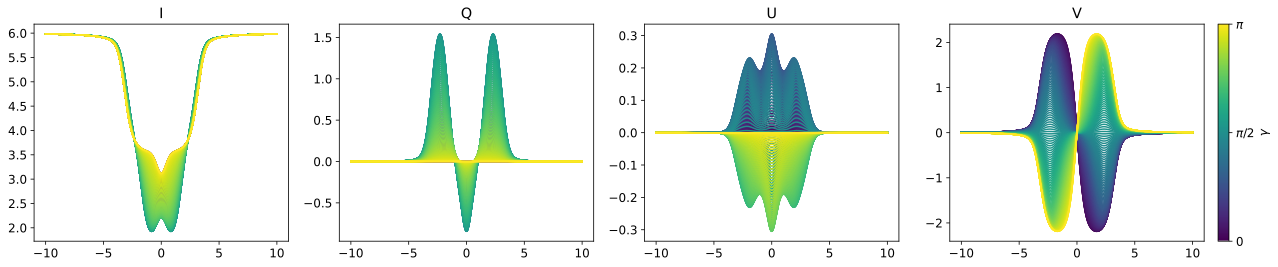

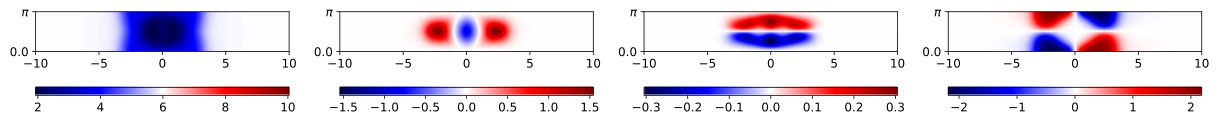

In [4]:
lam   = np.linspace(-10, 10, 1000)
gamma = np.linspace(0, np.pi, 200)
chi   = np.linspace(0, 2*np.pi, len(gamma))

titles = ["I", "Q", "U", "V"]
norm = matplotlib.colors.Normalize(vmin=gamma.min(), vmax=gamma.max(), clip=False)
colors = cm.viridis(numpy.linspace(0, 1, len(gamma)))

### Profiles
fig, ax = plt.subplots(1, 4, figsize=(25, 4))
spectrogram = np.zeros((4, len(lam), len(gamma)))

# Looping over gamma, plotting line for each
for j, gam in enumerate(gamma):
    vals = unno_rachkovsky(lam, gamma=gam, chi=0)
    spectrogram[..., j] = vals # Saving values to use in spectrogram
    for i in range(4):
        ax[i].plot(lam, vals[i], color=colors[j])

# Setting titles and adding colorbar
for i in range(4):
    ax[i].set_title(titles[i])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.viridis), ax=ax, label=r"$\gamma$", pad=0.01, ticks=np.linspace(0, np.pi, 3))
cbar.set_ticklabels(["0", r"$\pi/2$", r"$\pi$"])

### Spectrogram
fig, ax = plt.subplots(1, 4, figsize=(21, 4))
for i in [1, 2, 3]:
    ax[i].imshow(spectrogram[i].T, extent=[min(lam), max(lam), min(gamma), max(gamma)], cmap=cm.seismic, vmin=-abs(spectrogram[i]).max(), vmax=abs(spectrogram[i]).max())

    # Adding colorbar
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('bottom', size='20%', pad=0.5)
    norm = matplotlib.colors.Normalize(vmin=-abs(spectrogram[i]).max(), vmax=abs(spectrogram[i]).max(), clip=False)
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.seismic), cax=cax, orientation="horizontal")
    
    # Setting ticks to pi
    ax[i].set_yticks([0, np.pi])
    ax[i].set_yticklabels(["0.0", r"$\pi$"])

# Setting I separately since it is normalized by continuum, not 0
ax[0].imshow(spectrogram[0].T, extent=[min(lam), max(lam), min(gamma), max(gamma)], cmap=cm.seismic, vmin=spectrogram[0].min(), vmax=2*spectrogram[0].max()-spectrogram[0].min())
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('bottom', size='20%', pad=0.5)
norm = matplotlib.colors.Normalize(vmin=spectrogram[0].min(), vmax=2*spectrogram[0].max()-spectrogram[0].min(), clip=False)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.seismic), cax=cax, orientation="horizontal")
ax[0].set_yticks([0, np.pi])
ax[0].set_yticklabels(["0.0", r"$\pi$"])

plt.show()

In the top row we have plotted line profiles for all Stokes parameters for varying magnetic inclination, respective to the rightmost colorbar. The horizontal axis is dimensionless wavelength, while the vertical is value of the respective Stokes parameter. In the lower row we have added spectrograms for wavelength and angle $\gamma$, with equal ranges as the line plots. The colors indicate Stokes parameter strength with individual colorbars located below. Polarization parameter colours are normalized to 0, while the intensity is normalized to the continuum value. Looking at the line plots give a good indication of shape, while the spectrograms are better when studying change with angle.

We can see all components are symmetric around $\pi/2$, though while $I$ and $Q$ reach their extremes at this angle, the other components $U, V$ are zero here. We also see that at $0$ and $\pi$ all components are equal, except for $V$ which is antisymmetric, just as we saw in the last exercise.

Next we do the same for the azimuthal angle $\chi\in[0, 2\pi]$ while fixing $\gamma=\pi/4$:

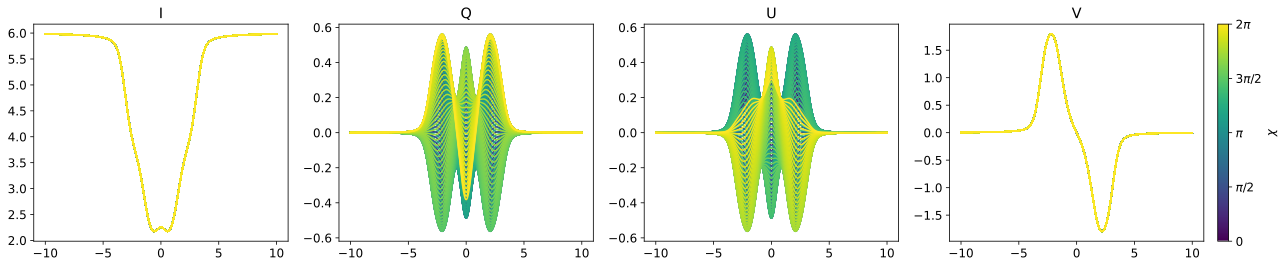

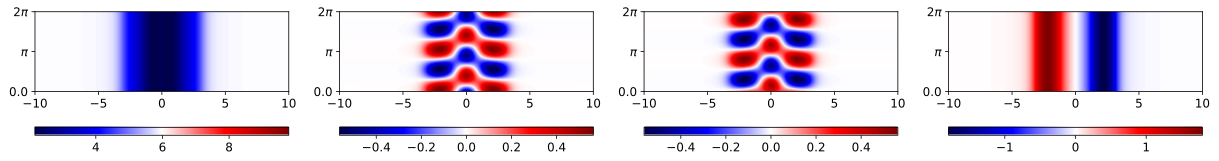

In [5]:
norm = matplotlib.colors.Normalize(vmin=chi.min(), vmax=chi.max(), clip=False) #Normalized color-range for chi
colors = cm.viridis(numpy.linspace(0, 1, len(chi)))

### Profiles
fig, ax = plt.subplots(1, 4, figsize=(25, 4))
spectrogram = np.zeros((4, len(lam), len(chi)))

# Looping over gamma, plotting line for each
for j, ch in enumerate(chi):
    vals = unno_rachkovsky(lam, gamma=np.pi/4, chi=ch)
    spectrogram[..., j] = vals # Saving values to use in spectrogram
    for i in range(4):
        ax[i].plot(lam, vals[i], color=colors[j])

# Setting titles and adding colorbar        
for i in range(4):
    ax[i].set_title(titles[i])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.viridis), ax=ax, label=r"$\chi$", pad=0.01, ticks=np.linspace(0, 2*np.pi, 5))
cbar.set_ticklabels(["0", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])

### Spectrogram
fig, ax = plt.subplots(1, 4, figsize=(21, 4))
for i in [1, 2, 3]:
    ax[i].imshow(spectrogram[i].T, extent=[min(lam), max(lam), min(chi), max(chi)], cmap=cm.seismic, vmin=-abs(spectrogram[i]).max(), vmax=abs(spectrogram[i]).max())
    
    # Adding colorbar
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('bottom', size='10%', pad=0.5)
    norm = matplotlib.colors.Normalize(vmin=-abs(spectrogram[i]).max(), vmax=abs(spectrogram[i]).max(), clip=False)
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.seismic), cax=cax, orientation="horizontal")
    
    # Setting ticks to pi
    ax[i].set_yticks([0, np.pi, 2*np.pi])
    ax[i].set_yticklabels(["0.0", r"$\pi$", r"$2\pi$"])

# Setting I separately since it is normalized by continuum, not 0
ax[0].imshow(spectrogram[0].T, extent=[min(lam), max(lam), min(chi), max(chi)], cmap=cm.seismic, vmin=spectrogram[0].min(), vmax=2*spectrogram[0].max()-spectrogram[0].min())
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('bottom', size='10%', pad=0.5)
norm = matplotlib.colors.Normalize(vmin=spectrogram[0].min(), vmax=2*spectrogram[0].max()-spectrogram[0].min(), clip=False)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.seismic), cax=cax, orientation="horizontal")
ax[0].set_yticks([0, np.pi, 2*np.pi])
ax[0].set_yticklabels(["0.0", r"$\pi$", r"$2\pi$"])

plt.show()

Here we can see that only the $Q$ and $U$ components are affected by the azimuthal angle $\chi$, which is as expected since they only have $\gamma$ dependencies in their profiles. The $Q$ and $U$ components still display the same symmetry for additions of $180º$ in this angle as well.

Next we look at a specific case with base parameters $S_0 = 1$, $S_1=5$, $\eta_\nu=5$, $a=0.05$, $\bar{g}=2.5$, $\Delta\lambda_B/\Delta\lambda_D = 1.5$, $\gamma=\pi/4$, and $\chi=0$. By plotting we will see that we will get a case with fully separated Zeeman components. However they have different amplitudes, and we wish to make it so they are equal. Hence we wish to find which parameters change their relative strength. These parameters are the relative extinction $\eta_\nu$, which controls the line amplitude/extinction, and the inclination $\gamma$, which affects the line of sight field. We change these parameters such that the three amplitudes are equal:

Text(0.5, 1.0, '$\\eta_\\nu=12.5$')

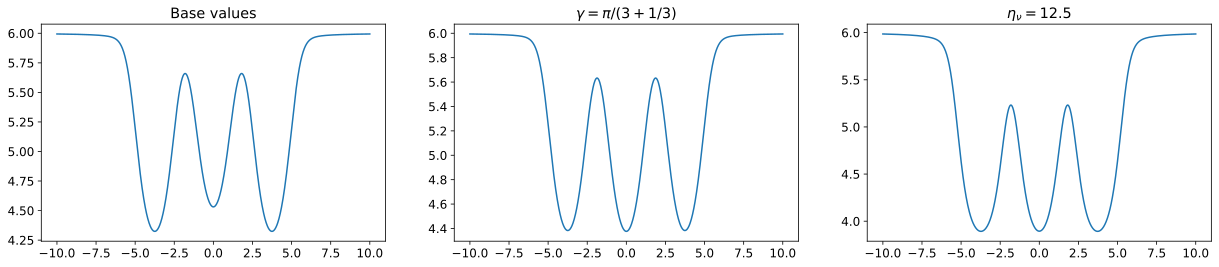

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(21, 4))
I = [unno_rachkovsky(lam, s0=1, s1=5, eta=5,    a=0.05, g_eff=2.5, delta_ratio=1.5, gamma=np.pi/4,       chi=0)[0],
     unno_rachkovsky(lam, s0=1, s1=5, eta=5,    a=0.05, g_eff=2.5, delta_ratio=1.5, gamma=np.pi/(3+1/3), chi=0)[0],
     unno_rachkovsky(lam, s0=1, s1=5, eta=12.5, a=0.05, g_eff=2.5, delta_ratio=1.5, gamma=np.pi/4,       chi=0)[0]]
for i in range(3):
    ax[i].plot(lam, I[i])
ax[0].set_title("Base values")
ax[1].set_title(r"$\gamma=\pi/(3+1/3)$")
ax[2].set_title(r"$\eta_\nu=12.5$")

At the left we have the unchanged line profile with split lines. In the middle we have changed only the inclination to $\gamma=\pi/(3+1/3)$, which results in equal lines, and to the right is the line profile for $\eta_\nu = 12.5$, which also gives equal lines.

Finally we look at the importance of magneto-optical effects, where we plot the line profiles for $\gamma=\pi/4$ and $\chi=0, \pi/4$ with and without the effects:

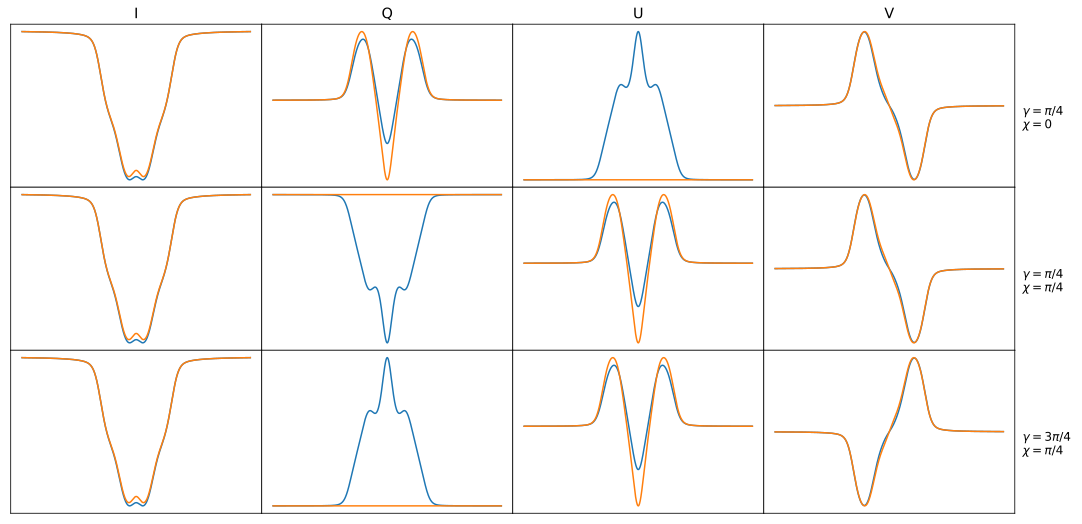

In [7]:
fig, ax = plt.subplots(3, 4, figsize=(18, 9))
# chi = 0
vals_mo = unno_rachkovsky(lam, gamma=np.pi/4, chi=0)
vals_no_mo = unno_rachkovsky(lam, gamma=np.pi/4, chi=0, no_mo=True)
for i in range(4):
    ax[0, i].plot(lam, vals_mo[i])
    ax[0, i].plot(lam, vals_no_mo[i])
    ax[0, i].set_title(titles[i])
# chi = pi/4
vals_mo = unno_rachkovsky(lam, gamma=np.pi/4, chi=np.pi/4)
vals_no_mo = unno_rachkovsky(lam, gamma=np.pi/4, chi=np.pi/4, no_mo=True)
for i in range(4):
    ax[1, i].plot(lam, vals_mo[i])
    ax[1, i].plot(lam, vals_no_mo[i])
# gamma = 0
vals_mo = unno_rachkovsky(lam, gamma=3*np.pi/4, chi=np.pi/4)
vals_no_mo = unno_rachkovsky(lam, gamma=3*np.pi/4, chi=np.pi/4, no_mo=True)
for i in range(4):
    ax[2, i].plot(lam, vals_mo[i])
    ax[2, i].plot(lam, vals_no_mo[i])

for j in range(3):
    ax[j, -1].yaxis.set_label_position("right")
    for i in range(4):
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
ax[0, -1].set_ylabel(" $\gamma = \pi/4$ \n $\chi = 0$", rotation="horizontal", horizontalalignment="left")
ax[1, -1].set_ylabel(" $\gamma = \pi/4$ \n $\chi = \pi/4$", rotation="horizontal", horizontalalignment="left")
ax[2, -1].set_ylabel(" $\gamma = 3\pi/4$ \n $\chi = \pi/4$", rotation="horizontal", horizontalalignment="left");

Lines in orange are lines with magneto-optical effects, while the blue lines are without. The top row is plotted for $\gamma=\pi/4, \chi = 0$, the middle row for $\gamma=\pi/4, \chi=\pi/4$, and the lower for $\gamma = 3\pi/4, \chi=pi/4$. We can see that in each case the effects are neglible for $I$ and $V$, but quite significant for $Q$ and $U$. In the case for $\chi = 0$, the magneto-optical effects effectively eliminate the $U$ component, while $Q$ is slightly affected. For $\chi = \pi/4$ this is reversed, where $U$ is only slightly affected but $Q$ is nearly eliminated. Variation in $\gamma$ does not seem to change how the magneto-optical effects affect the profiles.

### Exercise 3: Milne-Eddington lines from the FALC model

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Calculate the effective Landé factor for the Fe I 617.3 nm line. Does this line exhibit normal or anomalous Zeeman effect?
    
* The weak field approximation is valid when $\bar{g}\Delta\lambda_B/\Delta\lambda_D \ll 1$. In Project 3, you worked with observations of the 617.3 nm line, and inferred a maximum magnetic field strength of about 0.2 T. Is the weak field approximation valid in this case? Justify.
    
* Is the Unno-Rachkovsky solution appropriate for the Fe I 617.3 nm line with the FALC model? Test this by comparing the disk-centre intensity computed in LTE as you did in Project 5, with the intensity (B=0) given by Unno-Rachkovsky. To obtain the mean quantities for the Unno-Rachkovsky solution, you will need to find the formation range of the spectral line and in that region do a linear fit of $B_\lambda(T)$ vs $\tau_{500}$ to extract $S_0$ and $S_1$ (the other quantities such as $\Delta\lambda_D$ can be taken as the average in the region).

* Consider the Unno-Rachkovsky solution for Fe I 617.3 nm with parameters found in the previous question, assume a vertical magnetic field. What value of B would you need to see the split between $\sigma_r$ and $\sigma_b$ in the intensity profile?

* Repeat the previous question but for the Ti I 2.221 $\mu$m line, accounting for all Zeeman components. (You will need to extract the mean quantities for this line using the same process as before.) What value of B would you need to see the split among the individual $\sigma_b$ components (not just between $\sigma_r$ and $\sigma_b$)?

</div>

In this exercise...

The Fe I 617.3 nm line is a result of the $^5D_0\rightarrow ^5P_1$ transition. We use the same method as is exercise 1 to calculate the effective Landè factor for this transition:

In [8]:
gP = g_LS(1, 2, 1)
gD = g_LS(2, 2, 0)
print(r"Effective Landè factor:", g_eff(gP, gD, 1, 0))

Effective Landè factor: 2.5


We get an effective Landè factor $\bar{g} = 2.5$. Normal Zeeman effect occurs when the line is split into exactly three components, and occurs when the sum over spins in either level (or in total) is equal to zero. We have $J=0$ for level $^5D_0$, meaning we should expect the line to exhibit normal splitting.

A magnetic field with strength of 0.2 Tesla is quite strong and whether the weak field approximation is valid is difficult to tell without calculation. We have Zeeman and Doppler broadening given as:

\begin{align*}
    \Delta \lambda_B &= \frac{e}{4\pi m_e c}\lambda_0^2 B \\
    \Delta \lambda_D &= \frac{\lambda_0}{c}\sqrt{\frac{2k_BT}{m}+v^2_{\rm turb}}
\end{align*}

For the surface of the sun we have $B_{\rm max}\approx0.2\ {\rm T}$, $T\approx5778\ {\rm K}$, and $v_{\rm turb}\approx1.5\ {\rm km/s}$. We estimate the surface composition as 75% hydrogen and 25% helium, giving a mass of $m\approx1.75m_p$ This means the weak field approximation for $\lambda_0 = 617.3\ {\rm nm}$ is roughly:

\begin{align*}
    \bar{g}\Delta\lambda_B/\Delta\lambda_D \approx 2.5 \cdot 3.56 \ {\rm pm} / 15.51 \ {\rm pm} \approx 0.57
\end{align*}

With the estimates made the weak field approximation $\bar{g}\Delta\lambda_B/\Delta\lambda_D \ll 1$ is not valid in this case. This matches our findings from project 3, where we found the magnetic field to have a noticeable effect on line width.

Next we wish to compare the intensity resulting from the Unno-Rachkovsky solution and the FALC-based LTE intensity we found in project 5. We load the FALC model:

In [9]:
def read_table_units(filename):
    """
    Reads a table in a text file, formatted with column names in first row,
    and unit names on second row. Any deviation from this format will fail.
    
    Modified to use np instead of numpy
    """
    tmp = np.genfromtxt(filename, names=True)
    unit_names = open(filename).readlines()[1][1:].split()
    # Convert to astropy QTable to have units
    data = QTable(tmp)
    # Assign units to quantities in table, use SI units
    for key, unit in zip(data.keys(), unit_names):
        data[key].unit = unit
        data[key] = data[key].si  # We don't want to use deprecated units
    return data

falc = read_table_units("falc.dat")
h_FALC       = falc['height'].to('km')
tau_500_FALC = falc['tau_500']
T_FALC       = falc['temperature']
N_H_FALC     = falc['hydrogen_density']
N_p_FALC     = falc['proton_density']
N_e_FALC     = falc['electron_density']
P_FALC       = falc['pressure']
P_ratio_FALC = falc['p_ratio']
v_turb_FALC  = falc['v_turb']
colmass_FALC = falc['colmass']

Then we import functions needed to calculate the LTE intensity. See project 5 for details:

In [10]:
def compute_hminus_cross_section(wavelength, temperature, electron_density):
    """
    Computes the H minus extinction cross section, both free-free and
    bound-free as per Gray (1992).
    
    Modified to use np instead of numpy, and u, con instead of units, constants
    """
    # Broadcast to allow function of temperature and wavelength
    temp = temperature[..., nax]
    wave = wavelength[nax]
    theta = 5040 * u.K / temp
    electron_pressure = electron_density[..., nax] * con.k_B * temp
    # Compute bound-free opacity for H-, following Gray 8.11-8.12
    sigma_coeff = np.array([2.78701e-23, -1.39568e-18,  3.23992e-14, -4.40524e-10,
                               2.64243e-06, -1.18267e-05,  1.99654e+00])
    sigma_bf = np.polyval(sigma_coeff, wave.to_value('AA'))
    sigma_bf = sigma_bf * 1.e-22 * u.m ** 2
    # Set to zero above the H- ionisation limit at 1644.4 nm
    sigma_bf[wave > 1644.2 * u.nm] = 0.
    # convert into bound-free per neutral H atom assuming Saha,  Gray p156
    k_const = 4.158E-10 * u.cm ** 2 / u.dyn
    gray_saha = k_const * electron_pressure.cgs * theta ** 2.5 * 10. ** (0.754 * theta)
    kappa_bf = sigma_bf * gray_saha                    # per neutral H atom
    # correct for stimulated emission
    kappa_bf *= (1 - np.exp(-con.h * con.c / (wave * con.k_B * temp))) 

    # Now compute free-free opacity, following Gray 8.13
    # coefficients for 4th degree polynomials in the log of wavelength (in AA)
    coeffs = np.array([[-0.0533464, 0.76661, -1.685, -2.2763],
                       [-0.142631, 1.99381, -9.2846, 15.2827],
                       [-0.625151, 10.6913, -67.9775, 190.266, -197.789]])
    log_wave = np.log10(wave.to_value('AA'))
    log_theta = np.log10(theta.value)
    tmp = 0
    for i in range(3):
        tmp += np.polyval(coeffs[i], log_wave) * (log_theta ** i)
    kappa_ff = electron_pressure * (10 ** tmp) 
    kappa_ff = kappa_ff * 1e-26 * (u.cm ** 4) / u.dyn
    return (kappa_bf + kappa_ff).si

def read_atom(filename):
    """
    Reads atom structure from text file.
    Modified version of class Atom function.
    """
    tmp = np.loadtxt(filename, unpack=True)
    n_stages = int(tmp[2].max()) + 1
    max_levels = 0
    
    for i in range(n_stages):
        max_levels = max(max_levels, (tmp[2] == i).sum())
    
    chi = np.empty((n_stages, max_levels))
    chi.fill(np.nan)
    g = np.copy(chi)
    
    for i in range(n_stages):
        nlevels = (tmp[2] == i).sum()
        chi[i, :nlevels] = tmp[0][tmp[2] == i]
        g[i, :nlevels] = tmp[1][tmp[2] == i]

    chi = (chi / u.cm).to('aJ', equivalencies=u.spectral())
    chi_ion = chi[:, 0].copy()
    chi = chi - chi_ion[:, nax]
    return n_stages, g, chi, chi_ion

def compute_ionisation(temperature, electron_density, filename, partitions):
    """
    Computes ionisation fractions according to the Saha law.
    Modified version of class Atom function.
    """
    n_stages, g, chi, chi_ion = read_atom(filename)
    partition_function = partitions
    saha_const = ((2 * np.pi * con.m_e * con.k_B * temperature) / 
                  (con.h ** 2)) ** (3 / 2)
    nstage = np.zeros_like(partition_function) / u.m ** 3
    nstage[0] = 1. / u.m ** 3
    for r in range(n_stages - 1):
        nstage[r + 1] = (nstage[r] / electron_density * 2 * saha_const *
                         partition_function[r + 1] / partition_function[r] * 
                         np.exp(-chi_ion[r + 1, nax] / 
                                   (con.k_B * temperature[nax])))
    return nstage / np.nansum(nstage, axis=0)

def compute_excitation(temperature, filename, partitions):
    """
    Computes the level populations relative to the ground state,
    according to the Boltzmann law.
    Modified version of class Atom function.
    """
    n_stages, g, chi, chi_ion = read_atom(filename)
    pfunc = partitions
    temp = temperature[nax, nax]
    g_ratio = g[..., nax] / pfunc[:, nax]  # relative to total number of atoms in this stage
    chi = chi[..., nax]
    return g_ratio * np.exp(-chi / (con.k_B * temp))

def compute_populations(temperature, electron_density, filename, partitions):
    """
    Computes relative level populations for all levels and all
    ionisation stages using the Bolzmann and Saha laws.
    Modified version of class Atom function.
    """
    return (compute_excitation(temperature, filename, partitions) * 
            compute_ionisation(temperature, electron_density, filename, partitions)[:, nax])

def extinction(lam, thomson=False, extra_alpha=0):
    """Calculates H- extinction factor for given wavelength
       Optional argument to include Thomson cross section
       or to add another extinction to total"""

    # H- extinction from formula
    alpha = np.zeros((len(lam), len(h_FALC))) # Dimensions: wavelength times # of falc points
    for i in range(len(h_FALC)): # looping over height
        alpha[:, i] = ( compute_hminus_cross_section(lam, T_FALC[i], N_e_FALC[i])[0].to('m2') # H- cross-section in m^2
                       *(N_H_FALC[i] - N_p_FALC[i]))                                          # times # density of neutral hydrogen
    alpha *= u.m**-1
    
    # Adding Thompson scattering
    if thomson:
        alpha = alpha + con.sigma_T*N_e_FALC

    # Adding optional extra alpha
    alpha = alpha + extra_alpha
    
    # Integrating over height to get optical depth
    tau = -cumtrapz(alpha.to("m-1"), h_FALC.to('m'), axis=1)

    return alpha, tau

def line_extinction(lam, height, filename, lam0, m, f_lu, g_l, g_u, A_E, dr, Z, chi_inf, chi_u, chi_l, partitions):
    """
    Calculates line extinction given line parameters.
    """
    # extracting values from FALC for readability
    idx = np.argmin(abs(h_FALC - height)) # where height matches best with FALC
    N_H = N_H_FALC[idx]
    N_e = N_e_FALC[idx]
    T = T_FALC[idx]
    P_g = (P_FALC*P_ratio_FALC)[idx]

    # finding relative population fractions at all levels/ionization stages
    LTE_pop_frac = compute_populations(T, N_e, filename, partitions[:, idx][:, nax])
    
    # principal quantum numbers n for upper and lower levels u, l
    nu_star2 = 2.18 * u.aJ * Z**2 / (chi_inf - chi_u)
    nl_star2 = 2.18 * u.aJ * Z**2 / (chi_inf - chi_l)
    
    # natural broadening due to radiation and Van der Waals broadening, added together
    # logarithms do not like units, so they are converted and added back manually
    gamma_rad = 6.67e13 * g_l/g_u * f_lu/(lam.to("nm").value**2) * u.s**-1
    log1 = 0.4*np.log10(dr)
    log2 = np.log10(P_g.to("Ba").value)
    log3 = 0.7*np.log10(T.to("K").value)
    gamma_vdW = 10**(6.33 + log1 + log2 - log3) * u.s**-1
    gamma = gamma_rad + gamma_vdW

    # broadening due to thermal motion
    dlam_D = lam0/con.c * np.sqrt(2*con.k_B*T/m + v_turb_FALC[idx]**2)

    # line dampening, often called a
    damping = lam**2/(4*np.pi*con.c) * gamma/dlam_D

    # dimensionless wavelength in units of broadening
    u_ = (lam - lam0)/dlam_D
    
    alpha = (  con.e.si**2/(4*con.eps0*con.m_e*con.c)       # various constants
             * lam**2/con.c                                 # conversion factor from frequency to wavelength
             * LTE_pop_frac * N_H * A_E * f_lu              # level population information
             * voigt(damping, u_)/(np.sqrt(np.pi) * dlam_D) # damped line profile (Voigt)
             * (1-np.exp(-con.h*con.c/(lam*con.k_B*T))))    # compensation for stimulated emission
    
    return alpha.to("Mm-1") #returned in suitably sized unit

A problem this time around is that we cannot calculate the partition function for Fe and Ti, as they are not suited for our previous method. Therefore we use a set of previously calculated values and interpolate/extrapolate using the corresponding temperatures:

In [11]:
theta = numpy.arange(0.2, 2.2, 0.2)
temp_tab = (5040. * units.K / theta)
log10_Ur_FeI  = numpy.array([3.760, 2.049, 1.664, 1.519, 1.446, 1.402, 1.372, 1.350, 1.332, 1.317])
log10_Ur_FeII = numpy.array([2.307, 1.881, 1.749, 1.682, 1.638, 1.604, 1.575, 1.549, 1.525, 1.504])
log10_Ur_TiI  = numpy.array([4.159, 2.333, 1.818, 1.596, 1.480, 1.411, 1.367, 1.337, 1.316, 1.300])
log10_Ur_TiII = numpy.array([1.524, 1.435, 1.374, 1.338, 1.315, 1.300, 1.289, 1.280, 1.272, 1.265])

Ur_Fe = numpy.concatenate((10**interp1d(temp_tab, log10_Ur_FeI,  fill_value="extrapolate")(T_FALC)[nax],
                           10**interp1d(temp_tab, log10_Ur_FeII, fill_value="extrapolate")(T_FALC)[nax]),
                          axis = 0)
Ur_Ti = numpy.concatenate((10**interp1d(temp_tab, log10_Ur_TiI,  fill_value="extrapolate")(T_FALC)[nax],
                           10**interp1d(temp_tab, log10_Ur_TiII, fill_value="extrapolate")(T_FALC)[nax]),
                          axis = 0)

Then once we have all the ingredients required, we can calculate the lines as normal. The new line parameters are listed in the following table:

|                  | Fe I 617 | Ti I 2221 |
|------------------|-----------:|-----------:|
| Air wavelength (nm)  | 617.333         | 2221.122  |
| Lower level      |  4s ${}^5P_{1}$ | 4s $^5P_1$ |
| Upper level      |  4p ${}^5D_{0}$ | 4p  ${}^5D_1$|
| $\chi_{1,l}$ (aJ)| 0.35611  | 0.27774      |
| $\chi_{1,u}$ (aJ)| 0.67780 | 0.36715 |
| $\chi_{1,\infty}$ (aJ) | 1.26610 | 1.09274 | 
|   $g_l$          | 3     | 3      |
|   $g_u$          | 1     | 3      |
| $f_{lu}$         | 4.39e-4 | 5.55e-3  |
| $\Delta \overline{r^2}$ |   11.65  | 5.89   |
| Element abundance | 3.162e-5   | 8.913e-8     |
| Atomic mass (u) | 55.845   | 47.867 |

Note that our method of calculating the mean square radii do not work either, as it was only valid for hydrogenic species. Therefore we instead have the differences $\Delta \overline{r^2}$ given. We create a set of functions to calculate line extinctions (as they will be needed later) and integrate to get the lines:

In [12]:
def FeI_extinction(lam, mu=1):
    """
    Calculates line extinction of Fe I 617.3 nm line given a wavelength range and viewing angle µ
    """
    file      = "FeI_atom.txt" # file with level information
    lam0      = 617.333 * u.nm # central wavelength
    chi_l     = 0.35611 * u.aJ # lower level energy
    chi_u     = 0.67780 * u.aJ # upper level energy
    chi_inf   = 1.26610 * u.aJ # ionization energy
    g_l       = 3              # lower statistical weight
    g_u       = 1              # upper statistical weight
    f_lu      = 4.39e-4        # oscillator strength
    dr        = 11.65          # difference in mean square radii
    A_E       = 3.162e-5       # element abundance
    m         = 55.845 * con.u # particle mass
    Z         = 1              # ionization stage (1 = not ionized)
    part      = Ur_Fe          # partition function over FALC for Fe
    
    # finding actual line extinction, looping over height
    line_ext = np.zeros((len(lam), len(h_FALC)))
    for i, h in enumerate(h_FALC):
        line_ext[:, i] = np.nansum(
                            line_extinction(lam, h, file, lam0, m, f_lu, g_l, g_u,  # input and
                                            A_E, dr, Z, chi_inf, chi_u, chi_l, part # many constants
                                           )[Z-1, 1:2],                             # choosing relevant levels
                            axis=0)                                                 # sum over levels
    
    return line_ext * u.Mm**-1 # return with nice unit

def FeI_line(lam, mu=1):
    """
    Calculates line profile of Fe I 617.3 nm line given a wavelength range and viewing angle µ
    """
    line_ext = FeI_extinction(lam, mu)

    # Planck function for FALC temperatures and given wavelengths
    # con = astropy constants library, nax = new axis for broadcasting    
    BB = 2*con.h*con.c**2 / lam[..., nax]**5 * 1/(np.exp(con.h*con.c/(lam[..., nax]*con.k_B*T_FALC[nax])) - 1)
    BB *= u.sr**-1 # formula is per steradian
    
    # finding optical depth via total extinction = H-, Thomson, and line extinction
    tau = extinction(lam, thomson=True, extra_alpha=line_ext)[1]

    # intensity = integrating planck over height with optical depth and viewing angle
    BB = BB[:, 1:] # approximating due to nature of integration
    I = trapz(BB*np.exp(-tau/mu), tau/mu, axis=1)
    
    return I.to("kW m-2 sr-1 nm-1") # returning with nice units


def TiI_extinction(lam, mu=1):
    """
    Calculates line extinction of Ti I 2.222 µm line given a wavelength range and viewing angle µ
    """
    file      = "TiI_atom.txt"  # file with level information
    lam0      = 2221.122 * u.nm # central wavelength
    chi_l     = 0.27774 * u.aJ  # lower level energy
    chi_u     = 0.36715 * u.aJ  # upper level energy
    chi_inf   = 1.09274 * u.aJ  # ionization energy
    g_l       = 3               # lower statistical weight
    g_u       = 3               # upper statistical weight
    f_lu      = 5.55e-3         # oscillator strength
    dr        = 5.89            # difference in mean square radii
    A_E       = 8.913e-8        # element abundance
    m         = 47.867 * con.u  # particle mass
    Z         = 1               # ionization stage (1 = not ionized)
    part      = Ur_Ti           # partition function over FALC for Ti
    
    # finding actual line extinction, looping over height
    line_ext = np.zeros((len(lam), len(h_FALC)))
    for i, h in enumerate(h_FALC):
        line_ext[:, i] = np.nansum(
                            line_extinction(lam, h, file, lam0, m, f_lu, g_l, g_u,  # input and
                                            A_E, dr, Z, chi_inf, chi_u, chi_l, part # many constants
                                           )[Z-1, 1:2],                             # choosing relevant levels
                            axis=0)                                                 # sum over levels

    return line_ext * u.Mm**-1 #return with nice unit

def TiI_line(lam, mu=1):
    """
    Calculates line profile of Ti I 2.222 µm line given a wavelength range and viewing angle µ
    """
    line_ext = TiI_extinction(lam, mu)
    
    # Planck function for FALC temperatures and given wavelengths
    # con = astropy constants library, nax = new axis for broadcasting    
    BB = 2*con.h*con.c**2 / lam[..., nax]**5 * 1/(np.exp(con.h*con.c/(lam[..., nax]*con.k_B*T_FALC[nax])) - 1)
    BB *= u.sr**-1 # formula is per steradian
    
    # finding optical depth via total extinction = H-, Thomson, and line extinction
    tau = extinction(lam, thomson=True, extra_alpha=line_ext)[1]

    # intensity = integrating planck over height with optical depth and viewing angle
    BB = BB[:, 1:] # approximating due to nature of integration
    I = trapz(BB*np.exp(-tau/mu), tau/mu, axis=1)
    
    return I.to("kW m-2 sr-1 nm-1") # returning with nice units

Plotting the lines, we can see they are quite different from our last project:

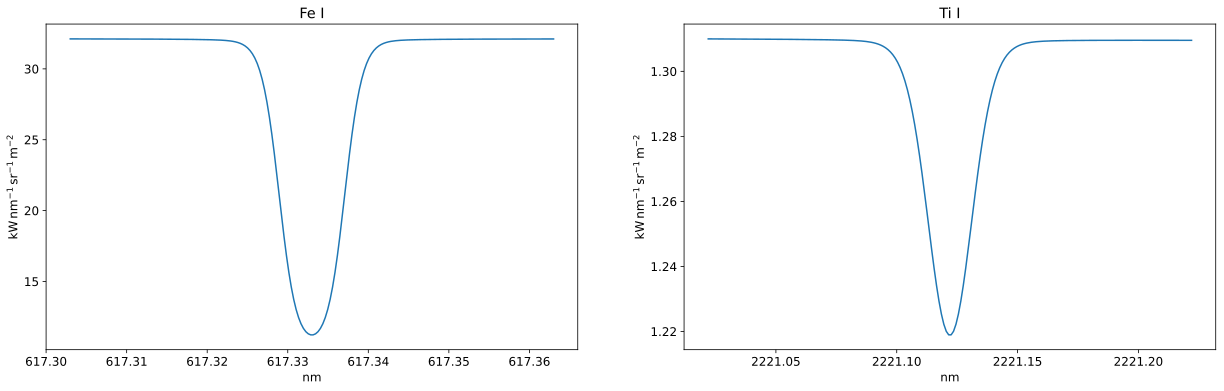

In [13]:
lam_Fe = np.linspace(617.303, 617.363, 200) * u.nm
I_Fe = FeI_line(lam_Fe)
lam_Ti = np.linspace(2221.022, 2221.222, 200) * u.nm
I_Ti = TiI_line(lam_Ti)

fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax[0].plot(lam_Fe, I_Fe)
ax[0].set_title("Fe I")
ax[1].plot(lam_Ti, I_Ti)
ax[1].set_title("Ti I")
ax[1].ticklabel_format(axis="x", style="plain", useOffset=False)
ax[1].locator_params(axis="x", nbins=6)

We do not have a line core reversal like previously. This is due to the different formation range for these new lines are different. We will show this because in order to calculate the Unno-Rachkovsky solution we need to find the unknown source function components $S_0$ and $S_1$. To start with, we use the same method as in project 5 to find the mean height of formation for both line core and wing, for both lines:

In [14]:
def formation(lam0, lam, line_ext):
    """
    Finds mean height of formation for wing and core of line.
    Takes lam0, the core wavelength, and lam, wavelength interval which includes core and wing,
    and line_ext, line extinction size (height x lam)
    """
    lam0 = np.array(lam0)[nax] * lam0.unit # workaround since extinction is broadcasted
    tau = extinction(lam0, thomson=True, extra_alpha=line_ext)[1]

    S_times_exp = BlackBody(T_FALC)(lam0)[1:] * np.exp(-tau)
    upper = trapz(h_FALC[1:]*S_times_exp, tau)
    lower = trapz(S_times_exp, tau)
    h_mean = upper/lower

    h_core = h_mean[np.argmin(abs(lam-lam0))] # where lam0 matches lam best
    h_wing = h_mean[0] # assumes index 0 to be wing
    
    return h_core, h_wing
    
lam0_Fe = 617.333 * u.nm
h_Fe = formation(lam0_Fe, lam_Fe, FeI_extinction(lam_Fe))
core_idx_Fe = np.argmin(abs(h_FALC-h_Fe[0]))
wing_idx_Fe = np.argmin(abs(h_FALC-h_Fe[1]))
print("FeI core index:", core_idx_Fe, "- FeI wing index:", wing_idx_Fe)

lam0_Ti = 2221.122 * u.nm
h_Ti = formation(lam0_Ti, lam_Ti, TiI_extinction(lam_Ti))
core_idx_Ti = np.argmin(abs(h_FALC-h_Ti[0])) - 4
wing_idx_Ti = np.argmin(abs(h_FALC-h_Ti[1]))
print("TiI core index:", core_idx_Ti, "- TiI wing index:", wing_idx_Ti)

FeI core index: 58 - FeI wing index: 67
TiI core index: 62 - TiI wing index: 68


Here we show the height indexes rather than the actual measure to highlight a problem with the Ti line. The difference in height of formation is much less than for the Fe line (in terms of data-points). Here we have fudged the lower index in order to have a bit wider area to work with, simply by experimentation to fit a later curve. Using this height of formation range, we fit the Unno-Rachkovsky source function $S_0 + S_1*\tau_{500}$ to the Planck function in this range:

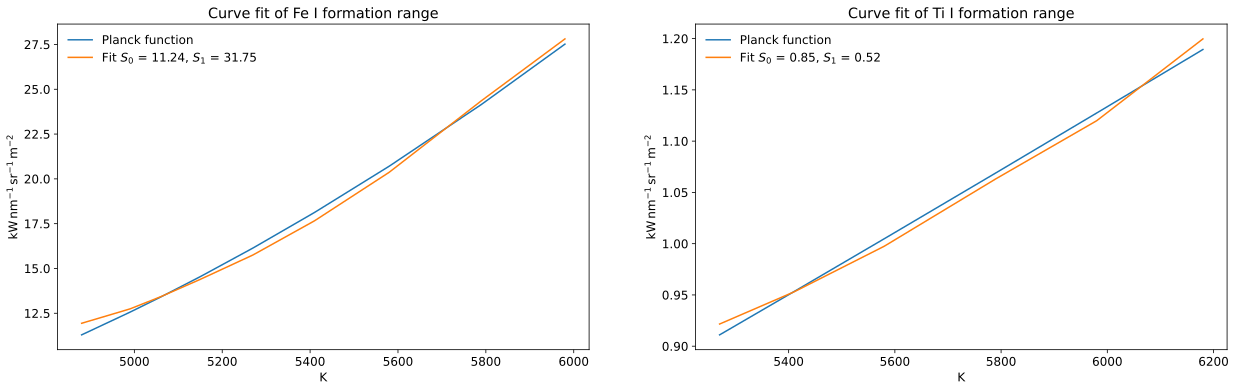

In [15]:
def fit_formation(lam0, h0, h1):
    T = T_FALC[h0:h1]
    BB = (2*con.h*con.c**2 / lam0**5 * 1/(np.exp(con.h*con.c/(lam0*con.k_B*T)) - 1) * u.sr**-1).to("kW m-2 sr-1 nm-1")
    BB = BB.value
    
    def Source_function(tau_500, S0, S1):
        return S0 + S1*tau_500
    
    popt, pcov = curve_fit(Source_function, tau_500_FALC[h0:h1], BB, p0=[1, 1])
    
    return popt, pcov

fit_Fe = fit_formation(lam0_Fe, core_idx_Fe, wing_idx_Fe)[0]
fit_Ti = fit_formation(lam0_Ti, core_idx_Ti, wing_idx_Ti)[0]

fig, ax = plt.subplots(1, 2, figsize=(21, 6))

Fe_idx = slice(core_idx_Fe, wing_idx_Fe)
BB_Fe = (2*con.h*con.c**2 / lam0_Fe**5 * 1/(np.exp(con.h*con.c/(lam0_Fe*con.k_B*T_FALC[Fe_idx])) - 1) * u.sr**-1).to("kW m-2 sr-1 nm-1")
fit_Fe *= BB_Fe.unit
ax[0].plot(T_FALC[Fe_idx], BB_Fe, label="Planck function")
ax[0].plot(T_FALC[Fe_idx], fit_Fe[0] + fit_Fe[1]*tau_500_FALC[Fe_idx], label=r"Fit $S_0$ = {:.2f}, $S_1$ = {:.2f}".format(fit_Fe[0].value, fit_Fe[1].value))
ax[0].set_title("Curve fit of Fe I formation range")
ax[0].legend()

Ti_idx = slice(core_idx_Ti, wing_idx_Ti)
BB_Ti = (2*con.h*con.c**2 / lam0_Ti**5 * 1/(np.exp(con.h*con.c/(lam0_Ti*con.k_B*T_FALC[Ti_idx])) - 1) * u.sr**-1).to("kW m-2 sr-1 nm-1")
fit_Ti *= BB_Ti.unit
ax[1].plot(T_FALC[Ti_idx], BB_Ti, label="Planck function")
ax[1].plot(T_FALC[Ti_idx], fit_Ti[0] + fit_Ti[1]*tau_500_FALC[Ti_idx], label=r"Fit $S_0$ = {:.2f}, $S_1$ = {:.2f}".format(fit_Ti[0].value, fit_Ti[1].value))
ax[1].set_title("Curve fit of Ti I formation range")
ax[1].legend();

We get good fits for both curves, and values for $S_0, S_1$ which we can use. To actually plot the Unno-Rachkovsky lines however we need a lot of values which we have previously only set manually for imaginary lines. We do however have the means to calculate all, then simply using the average over the formation range. The dimensionless wavelength is given as distance from line core in doppler widths:

In [16]:
m_Fe = 55.845 * con.u
dlamD_Fe = np.mean(lam0_Fe / con.c * (2*con.k_B*T_FALC[Fe_idx]/m_Fe + v_turb_FALC[Fe_idx]**2)**0.5)
u_Fe = (lam_Fe - lam0_Fe)/dlamD_Fe

m_Ti = 55.845 * con.u
dlamD_Ti = np.mean(lam0_Ti / con.c * (2*con.k_B*T_FALC[Ti_idx]/m_Ti + v_turb_FALC[Ti_idx]**2)**0.5)
u_Ti = (lam_Ti - lam0_Ti)/dlamD_Ti

The ratio of line extinction to continuum extinction $\eta_\nu$ is just as simple as it sounds. We make sure to pick the values at line core, and mean over height:

In [17]:
eta_Fe = np.mean( ( FeI_extinction(lam_Fe, 1)                # line extinction
                   /extinction(lam_Fe, True)[0]              # continuum extinction
                  )[np.argmin(abs(lam_Fe-lam0_Fe)), Fe_idx]) # pick lam0, mean over height range

eta_Ti = np.mean( ( TiI_extinction(lam_Ti, 1)                
                   /extinction(lam_Ti, True)[0]              
                  )[np.argmin(abs(lam_Ti-lam0_Ti)), Ti_idx]) 

The dampening is calculated just as for the LTE lines, and we use the same values as given in the table:

In [18]:
### Fe
g_l  = 3
g_u  = 1
f_lu = 4.39e-4
dr   = 11.65
P_g = (P_FALC*P_ratio_FALC)[Fe_idx]

log1 = 0.4*np.log10(dr)
log2 = np.log10(P_g.to("Ba").value)
log3 = 0.7*np.log10(T_FALC[Fe_idx].to("K").value)
gamma_vdW = np.mean(10**(6.33 + log1 + log2 - log3) * u.s**-1)
gamma_rad = 6.67e13 * g_l/g_u * f_lu/(lam0_Fe.to("nm").value**2) * u.s**-1
gamma = gamma_rad + gamma_vdW
a_Fe = lam0_Fe**2/(4*np.pi*con.c) * gamma/dlamD_Fe

### Ti
g_l  = 3
g_u  = 3
f_lu = 5.55e-3
dr   = 5.89

gamma_rad = 6.67e13 * g_l/g_u * f_lu/(lam0_Ti.to("nm").value**2) * u.s**-1
log1 = 0.4*np.log10(dr)
P_g = (P_FALC*P_ratio_FALC)[Ti_idx]
log2 = np.log10(P_g.to("Ba").value)
log3 = 0.7*np.log10(T_FALC[Ti_idx].to("K").value)
gamma_vdW = np.mean(10**(6.33 + log1 + log2 - log3) * u.s**-1)
gamma = gamma_rad + gamma_vdW
a_Ti = lam0_Ti**2/(4*np.pi*con.c) * gamma/dlamD_Ti

And finally we calculate the same effective Landé factors as in exercise 1:

In [19]:
gP = g_LS(1, 2, 1)
gD = g_LS(2, 2, 0)
g_Fe = g_eff(gP, gD, 1, 0)

gP = g_LS(1, 2, 1)
gD = g_LS(2, 2, 1)
g_Ti = g_eff(gP, gD, 1, 1)

Using all these we calculate the Unno-Rachkovsky intensity and plot it alongside the LTE (here named FALC) lines. We are interested in comparing their shape, so we normalize them by their continuum:

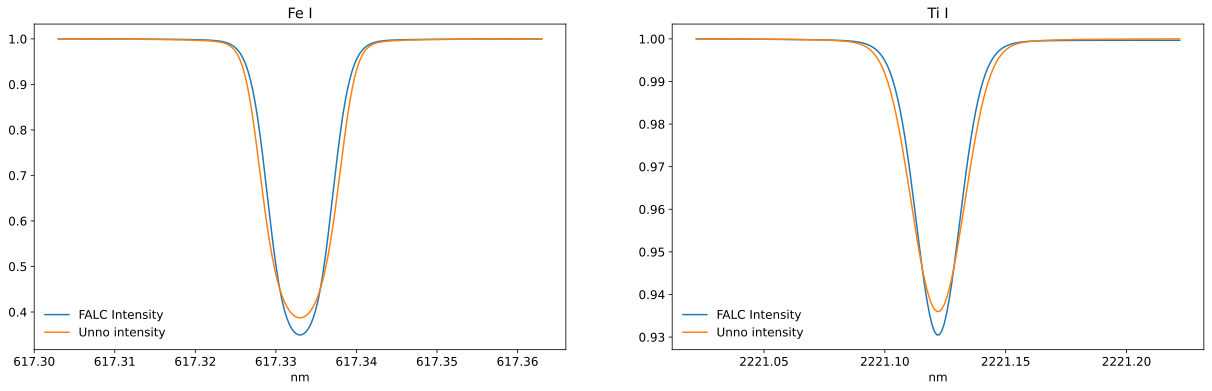

In [20]:
unno_Fe = unno_rachkovsky(u_Fe, s0=fit_Fe[0], s1=fit_Fe[1], eta=eta_Fe, a=a_Fe, g_eff=g_Fe, 
                          delta_ratio=0.0, gamma=0, chi=0, no_mo=False)[0]

unno_Ti = unno_rachkovsky(u_Ti, s0=fit_Ti[0], s1=fit_Ti[1], eta=eta_Ti, a=a_Ti, g_eff=g_Ti, 
                          delta_ratio=0.0, gamma=0, chi=0, no_mo=False)[0]

fig, ax = plt.subplots(1, 2, figsize=(21, 6))

ax[0].plot(lam_Fe, I_Fe/np.nanmax(I_Fe), label="FALC Intensity")
ax[0].plot(lam_Fe, unno_Fe/np.nanmax(unno_Fe), label="Unno intensity")
ax[0].set_title("Fe I")
ax[0].legend()

ax[1].plot(lam_Ti, I_Ti/np.nanmax(I_Ti), label="FALC Intensity")
ax[1].plot(lam_Ti, unno_Ti/np.nanmax(unno_Ti), label="Unno intensity")
ax[1].set_title("Ti I")
ax[1].legend()
ax[1].ticklabel_format(axis="x", style="plain", useOffset=False)
ax[1].locator_params(axis="x", nbins=6)

We can see that they end up very similar. In both cases the calculated FALC lines are a bit deeper and thinner, but overall they match very well. This is in part due to the fudging in mean height of formation, as the number of data-points were too few to get a good fit for the Ti I case. The formation height should still be centered around the same location however, so we can justify this fudging since the results should be very similar.

Finally we wish to split the lines into separate Zeeman components. For the iron line this is trivial with our setup, as we simply have to calculate the ratio between Zeeman and Doppler broadening $\Delta\lambda_B/\Delta\lambda_D$. We wish to see for which field strength the lines become completely split, so we plot it for different values:

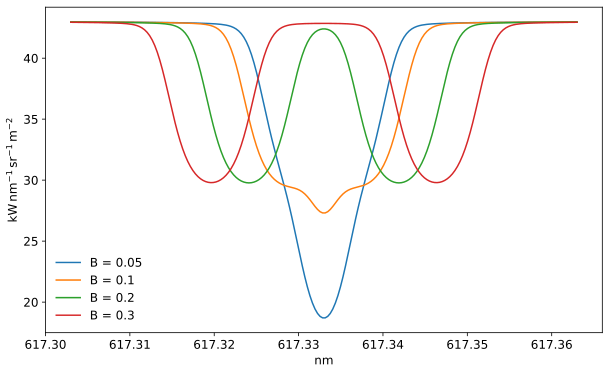

In [21]:
plt.figure(figsize=(10, 6))
for B in [0.05, 0.1, 0.2, 0.3]:
    dlamB_Fe = con.e.si/(4*np.pi*con.m_e*con.c) * lam0_Fe**2 * B*u.T
    d_ratio_Fe = dlamB_Fe / dlamD_Fe
    unno_Fe = unno_rachkovsky(u_Fe, s0=fit_Fe[0], s1=fit_Fe[1], eta=eta_Fe, a=a_Fe, g_eff=g_Fe, 
                              delta_ratio=d_ratio_Fe, gamma=0, chi=0, no_mo=False)[0]

    plt.plot(lam_Fe, unno_Fe, label=f"B = {B}")
plt.legend()

Here we used a completely vertical field $\gamma = 0$. We can see that the magnetic field has to reach above $B = 0.2 {\rm T}$ in order for the lines to be completely split. At $0.2 {\rm T}$ they only overlap a slight amount, and for $0.3 {\rm T}$ we can see the line core wavelength has reached continuum.

Doing the same for the Ti lines is a bit more complicated however, as the multiple components require a more thorough calculations. The $\phi_0, \phi_\pm$ components of the Unno-Rachkovsky solution get contributions from many different transitions, all which have different strengths. The transition strengths are encoded in the following function:

In [22]:
def zeeman_strength(J_l, J_u, M_l, M_u):
    """
    Calculates strengths of Zeeman components.
    """
    J, M = J_l, M_l
    if M_u - M_l == 1:
        if J_u - J_l == 1:
            strength = (3 * (J + M + 1) * (J + M + 2)) / (2 * (J + 1) * (2 * J + 1) * (2 * J + 3))
        elif J_u - J_l == 0:
            strength = (3 * (J - M) * (J + M + 1)) / (2 * J * (J + 1) * (2 * J + 1))
        elif J_u - J_l == -1:
            strength = (3 * (J - M) * (J - M - 1)) / (2 * J * (2 * J - 1) * (2 * J + 1))
        else:
            raise ValueError('Invalid transition, J_u - J_l != -1, 0, 1')
    elif M_u - M_l == 0:
        if J_u - J_l == 1:
            strength = (3 * (J - M + 1) * (J + M + 1)) / ((J + 1) * (2 * J + 1) * (2 * J + 3))
        elif J_u - J_l == 0:
            strength = 3 * M**2 / (J * (J + 1) * (2 * J + 1))
        elif J_u - J_l == -1:
            strength = (3 * (J - M) * (J + M)) / (J * (2 * J - 1) * (2 * J + 1))
        else:
            raise ValueError('Invalid transition, J_u - J_l != -1, 0, 1')
    elif M_u - M_l == -1:
        if J_u - J_l == 1:
            strength = (3 * (J - M + 1) * (J - M + 2)) / (2 * (J + 1) * (2 * J + 1) * (2 * J + 3))
        elif J_u - J_l == 0:
            strength = (3 * (J + M) * (J - M + 1)) / (2 * J * (J + 1) * (2 * J + 1))
        elif J_u - J_l == -1:
            strength = (3 * (J + M) * (J + M - 1)) / (2 * J * (2 * J - 1) * (2 * J + 1))
        else:
            raise ValueError('Invalid transition, J_u - J_l != -1, 0, 1')
    else:
        raise ValueError('Invalid transition, M_u - M_l != -1, 0, 1')
    return strength

We need to rewrite the function for Unno-Rachkovsky to use these. The new $\phi$ components follow the equation:

\begin{align*}
    \phi_q = \sum_{u, l} S_q^{J^l J^u} H\left(a, v + \left[g^uM_j^u-g^lM_j^l\right]\frac{\Delta\lambda_B}{\Delta\lambda_D} \right)
\end{align*}

For $q\equiv\Delta M_j=-1, 0, 1$. We make this simply as:

In [23]:
def unno_rachkovsky_Ti(u, s0=1, s1=5, eta=20, a=0.05, g_eff=1, 
                       delta_ratio=1.5, gamma=numpy.pi/3, chi=0, no_mo=False):
    """
    Calculates Stokes vector using Unno-Rachkovsky solution, for a given 
    source function S = s0 + s1 * tau.
    
    Added section to take multiple splitting for Ti I into account.
    Hardcoded for this specific case due to lack of time and exams.
    
    Parameters
    ----------
    u : 1-D array
        Dimensionless wavelength in Doppler width units
    s0, s1: scalar (astropy intensity units)
        Constants in the definition of source function.
    eta : scalar
        Ratio of line to continuum extinction, alpha_l / alpha_c.
    a: scalar
        Broadening of profile
    u: 1-D array
        Normalised wavelength scale. 
    g_eff: scalar
        Effective Lande factor.
    delta_ratio: scalar
        Ratio of Zeeman broadening to Doppler broadening.
    gamma: scalar
        Inclination angle of magnetic field
    chi: scalar
        Azimuth angle of magnetic field
    no_mo: bool
        If true, will not include magneto-optical effects.
    """
    phi_0 = 0
    phi_r = 0 
    phi_b = 0    
    Ju = 1
    Jl = 1
    gl = g_LS(1, 2, 1)
    gu = g_LS(2, 2, 1)
    mj_u_list = np.arange(-Ju, Ju+1, 1)
    mj_l_list = np.arange(-Jl, Jl+1, 1)
    for mj_u in mj_u_list:
        for mj_l in mj_l_list:
            dM = mj_u - mj_l
            if abs(dM) <= 1: # legal transition
                if dM == 0:
                    phi_0 += zeeman_strength(Jl, Ju, mj_l, mj_u) * voigt(a, u + (gu*mj_u - gl*mj_l)*delta_ratio)
                if dM == 1:
                    phi_r += zeeman_strength(Jl, Ju, mj_l, mj_u) * voigt(a, u + (gu*mj_u - gl*mj_l)*delta_ratio)
                if dM == -1:
                    phi_b += zeeman_strength(Jl, Ju, mj_l, mj_u) * voigt(a, u + (gu*mj_u - gl*mj_l)*delta_ratio)
            else: # illegal transition
                pass
    psi_0 = faraday(a, u)
    psi_r = faraday(a, u + g_eff * delta_ratio) 
    psi_b = faraday(a, u - g_eff * delta_ratio)
    
    phi_delta = 0.5 * (phi_0 - 0.5 * (phi_b + phi_r))
    phi_I = phi_delta * numpy.sin(gamma)**2 + 0.5 * (phi_b + phi_r)
    phi_Q = phi_delta * numpy.sin(gamma)**2 * numpy.cos(2 * chi)
    phi_U = phi_delta * numpy.sin(gamma)**2 * numpy.sin(2 * chi)
    phi_V = 0.5 * (phi_b - phi_r) * numpy.cos(gamma)
    
    psi_delta = 0.5 * (psi_0 - 0.5 * (psi_b + psi_r))
    psi_Q = psi_delta * numpy.sin(gamma)**2 * numpy.cos(2 * chi)
    psi_U = psi_delta * numpy.sin(gamma)**2 * numpy.sin(2 * chi)
    psi_V = 0.5 * (psi_b - psi_r) * numpy.cos(gamma)
    
    kI = 1 + eta * phi_I
    kQ = eta * phi_Q
    kU = eta * phi_U
    kV = eta * phi_V

    if no_mo:
        fQ = 0
        fU = 0
        fV = 0
    else:
        fQ = eta * psi_Q
        fU = eta * psi_U
        fV = eta * psi_V

    delta = (kI**4 + kI**2 * (fQ**2 + fU**2 + fV**2 - kQ**2 - kU**2 - kV**2) - 
             (kQ * fQ + kU * fU + kV * fV)**2)
    I = s0 + s1 / delta * kI * (kI**2 + fQ**2 + fU**2 + fV**2)
    Q = -s1 / delta * (kI**2 * kQ - kI * (kU * fV - kV * fU) + fQ * (kQ * fQ + kU * fU + kV * fV))
    U = -s1 / delta * (kI**2 * kU - kI * (kV * fQ - kQ * fV) + fU * (kQ * fQ + kU * fU + kV * fV))
    V = -s1 / delta * (kI**2 * kV + fV * (kQ * fQ + kU * fU + kV * fV))
    return I, Q, U, V

Then we plot the line(s) with the updated function:

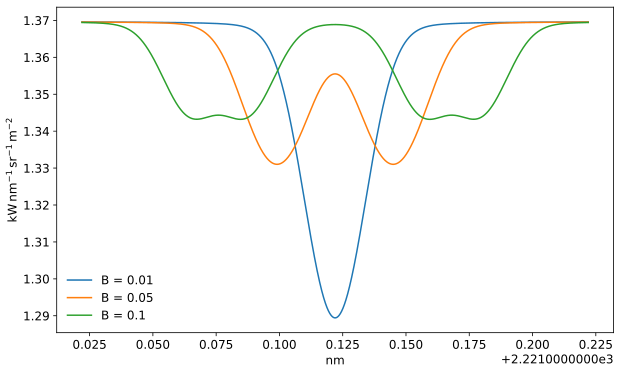

In [24]:
dlam = 0.1 * u.nm
lam_Ti_ext = np.linspace(lam0_Ti-dlam, lam0_Ti+dlam, 5000) #extended Ti wavelength range
u_Ti_ext = (lam_Ti_ext - lam0_Ti)/dlamD_Ti

plt.figure(figsize=(10, 6))
for B in [0.01, 0.05, 0.1]:
    dlamB_Ti = con.e.si/(4*np.pi*con.m_e*con.c) * lam0_Ti**2 * B*u.T
    d_ratio_Ti = dlamB_Ti / dlamD_Ti
    unno_Ti = unno_rachkovsky_Ti(u_Ti_ext, s0=fit_Ti[0], s1=fit_Ti[1], eta=eta_Ti, a=a_Ti, g_eff=g_Ti, 
                                 delta_ratio=d_ratio_Ti, gamma=0, chi=0, no_mo=False)[0]

    plt.plot(lam_Ti_ext, unno_Ti, label=f"B = {B}")
plt.legend()

Here we can see that for a magnetic field of $B = 0.1 {\rm T}$ we start to see the components split.